In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

from IPython.core.display import display, HTML
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
customer_train = pd.read_csv('customer_train.csv')
customer_test = pd.read_csv('customer_test.csv')
customer_train.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,894436,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,30.0,MAR,0.0,2018-03-20 09:10:16,1,Неруководящий сотрудник - обсл. Персонал
1,524526,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,20.0,UNM,0.0,2017-03-29 20:38:45,16,NaN
2,498134,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,25.0,UNM,0.0,2018-03-12 11:25:06,22,NaN
3,278941,NaN,NaN,UTL,CLS,NaN,UTL,UTL,M,25.0,NaN,NaN,2016-02-21 18:47:51,16,Неруководящий сотрудник - специалист
4,877312,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,40.0,MAR,0.0,2018-03-07 11:17:02,22,NaN


In [4]:
customer_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
customer_id           50000 non-null int64
product_0             1599 non-null object
product_1             23725 non-null object
product_2             4391 non-null object
product_3             6813 non-null object
product_4             2182 non-null object
product_5             33426 non-null object
product_6             2354 non-null object
gender_cd             49637 non-null object
age                   49690 non-null float64
marital_status_cd     31207 non-null object
children_cnt          44729 non-null float64
first_session_dttm    49997 non-null object
job_position_cd       50000 non-null int64
job_title             26497 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 5.7+ MB


In [5]:
customer_train['first_session_dttm'] = customer_train['first_session_dttm'].fillna(customer_train['first_session_dttm'][0])
customer_test['first_session_dttm'] = customer_test['first_session_dttm'].fillna(customer_test['first_session_dttm'][0])

In [6]:
stories_test = pd.read_csv('stories_reaction_test.csv')
stories_train = pd.read_csv('stories_reaction_train.csv')
stories_train.head()

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip
3,15,379,2018-05-23 05:41:43,skip
4,15,544,2018-07-25 02:16:29,view


In [7]:
stories_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473141 entries, 0 to 473140
Data columns (total 4 columns):
customer_id    473141 non-null int64
story_id       473141 non-null int64
event_dttm     473141 non-null object
event          473141 non-null object
dtypes: int64(2), object(2)
memory usage: 14.4+ MB


In [8]:
def date_convert(date_to_convert):
     return datetime.datetime.strptime(date_to_convert,"%Y-%m-%d %H:%M:%S").timestamp()

customer_train['first_session_dttm'] = customer_train['first_session_dttm'].apply(date_convert)
customer_test['first_session_dttm'] = customer_test['first_session_dttm'].apply(date_convert)

stories_train['event_dttm'] = stories_train['event_dttm'].apply(date_convert)
stories_test['event_dttm'] = stories_test['event_dttm'].apply(date_convert)

customer_train = customer_train.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
customer_test = customer_test.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [9]:
concat2 = pd.concat([stories_train[['story_id','event_dttm']],stories_test[['story_id','event_dttm']]])
concat2 = concat2.sort_values(['story_id','event_dttm']).reset_index(drop=True)
idst = list(set(concat2['story_id']))

concat2['timedelta_story'] = np.nan
concat2['timedelta_story'] = concat2.groupby('story_id')['event_dttm'].diff()
concat2['timedelta_story'] = concat2['timedelta_story'].fillna(0)

time_story = concat2.groupby('story_id').agg({'timedelta_story': ["mean", "std", "max",'min']})
time_story.columns = time_story.columns.droplevel(0)
time_story.columns = ['tds_mean','tds_std','tds_max','tds_min']

In [10]:
concat1 = pd.concat([stories_train[['customer_id','event_dttm']],stories_test[['customer_id','event_dttm']]])
concat1 = concat1.sort_values(['customer_id','event_dttm']).reset_index(drop=True)
idst = list(set(concat1['customer_id']))

concat1['timedelta_customer'] = np.nan
concat1['timedelta_customer'] = concat1.groupby('customer_id')['event_dttm'].diff()
concat1['timedelta_customer'] = concat1['timedelta_customer'].fillna(0)

time_id = concat1.groupby('customer_id').agg({'timedelta_customer': ["mean", "std", "max",'min']})
time_id.columns = time_id.columns.droplevel(0)
time_id.columns = ['tdc_mean','tdc_std','tdc_max','tdc_min']

In [11]:
stories_train = stories_train.merge(customer_train,on='customer_id',how='left')
stories_test = stories_test.merge(customer_test,on='customer_id',how='left')

stories_train['count_stories_by_customers'] = stories_train['customer_id'].map(pd.concat([stories_train['customer_id'],stories_test['customer_id']]).value_counts())
stories_test['count_stories_by_customers'] = stories_test['customer_id'].map(pd.concat([stories_train['customer_id'],stories_test['customer_id']]).value_counts())

stories_train['count_stories'] = stories_train['story_id'].map(pd.concat([stories_train['story_id'],stories_test['story_id']]).value_counts())
stories_test['count_stories'] = stories_test['story_id'].map(pd.concat([stories_train['story_id'],stories_test['story_id']]).value_counts())

stories_train = stories_train.merge(time_id,on='customer_id',how='left')
stories_test = stories_test.merge(time_id,on='customer_id',how='left')

stories_train = stories_train.merge(time_story,on='story_id',how='left')
stories_test = stories_test.merge(time_story,on='story_id',how='left')

gc.collect()

56

In [12]:
stories_test['event'] = stories_test.index
storyset = pd.concat([stories_train,stories_test])
storyset = storyset.sort_values('event_dttm').reset_index(drop=True)

storyset['timedelta_diff'] = storyset.groupby('customer_id')['event_dttm'].diff()

for i in range(-10,11):
    storyset['timedelta_diff_{}'.format(i)] = storyset.groupby('customer_id')['event_dttm'].diff(periods=i)

stories_train = storyset[storyset['answer_id'].isnull()]
stories_test = storyset[storyset['answer_id'].notnull()]

stories_test.index = stories_test['event']
stories_test.sort_index(inplace=True)
del stories_test['event'], stories_train['answer_id']

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone
from sklearn.model_selection import check_cv
from category_encoders import CatBoostEncoder

X_train = stories_train[['story_id', 'product_0','product_1','product_2','product_3','product_4','product_5','product_6', 'gender_cd','marital_status_cd','job_position_cd','age','job_title']]
X_test = stories_test[['story_id', 'product_0','product_1','product_2','product_3','product_4','product_5','product_6', 'gender_cd','marital_status_cd','job_position_cd','age','job_title']]

y_train = stories_train['event'].map({'dislike':0,'like':3,'skip':1,'view':2})

class TargetEncoderCV(BaseEstimator, TransformerMixin):
    def __init__(self, cv, **cbe_params):
        self.cv = cv
        self.cbe_params = cbe_params
    @property
    def _n_splits(self):
        return check_cv(self.cv).n_splits
    def fit_transform(self, X: pd.DataFrame, y) -> pd.DataFrame:
        self.cbe_ = []
        cv = check_cv(self.cv)
        cbe = CatBoostEncoder(
            cols=X.columns.tolist(),
            return_df=False,
            **self.cbe_params
        )

        X_transformed = np.zeros_like(X, dtype=np.float64)
        for train_idx, valid_idx in cv.split(X, y):
            self.cbe_.append(
                clone(cbe).fit(X.iloc[train_idx], y.iloc[train_idx])
            )
            X_transformed[valid_idx] = self.cbe_[-1].transform(
                X.iloc[valid_idx]
            )

        return pd.DataFrame(X_transformed, columns=X.columns)
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transformed = np.zeros_like(X, dtype=np.float64)
        for cbe in self.cbe_:
            X_transformed += cbe.transform(X) / self._n_splits
        return pd.DataFrame(X_transformed, columns=X.columns)

te_cv = TargetEncoderCV(KFold(n_splits=5))
X_train = te_cv.fit_transform(X_train, y_train)
X_test = te_cv.transform(X_test)

for col in X_test.columns:
    stories_train[col] = X_train[col]
    stories_test[col] = X_test[col]
    
del X_train
del X_test
gc.collect()

14

In [14]:
transactions = pd.read_csv('transactions.csv')
transactions = transactions[['customer_id','transaction_amt']].groupby('customer_id').agg({'transaction_amt': ["mean", "std", "nunique", "sum", "max"]})
transactions.columns = transactions.columns.droplevel(0)
transactions.columns = ['trx_mean','trx_std','trx_unique','trx_sum','trx_max']

stories_train = stories_train.merge(transactions,on='customer_id',how='left')
stories_test = stories_test.merge(transactions,on='customer_id',how='left')

del transactions,customer_train,customer_test
gc.collect()

111

In [15]:
def SelectMCCS(df, columnname):
    top150 = [4121, 5541, 5331, 5921, 4111, 5651, 5999, 5691, 4812, 5732, 7832, 5712, 5200, 5399, 5499, 5992, 4814, 5816, 5812, 8999, 5977, 5722, 5912, 5941, 7994, 4816, 8099, 7230, 5735, 5311, 4900, 5641, 5964, 5995, 4112, 5813, 4789, 6300, 5942, 7011, 4511, 5533, 5699, 5661, 5211, 5462, 5261, 7922, 5945, 5993, 7399, 5814, 4215, 5734, 4131, 5441, 5943, 5983, 7997, 5947, 5655, 4722, 8071, 5811, 5511, 7278, 9399, 4899, 7299, 5621, 9311, 5451, 6051, 9402, 7991, 4784, 5422, 8011, 5968, 5542, 7538, 8043, 7512, 7311, 8220, 7999, 5631, 3011, 8021, 8299, 7338, 7221, 5815, 7523, 6540, 9222, 5611, 7542, 7699, 5944, 5192, 7995, 4214, 5411, 5719, 5310, 7996, 5948, 5309, 7841, 7298, 5817, 5300, 5251, 5044, 3640, 5094, 7379, 7998, 5131, 5111, 7941, 4411, 7296, 8398, 7372, 5571, 7032, 7210, 5193, 5122, 5976, 5713, 5532, 5949, 5963, 2741, 8351, 6211, 5045, 7911, 7395, 7531, 8244, 5013, 5039, 5946]

    df.loc[df[columnname].map(lambda x: x not in top150), columnname] = 'other'
    df.loc[df[columnname].map(lambda x: x not in top150), columnname] = 'other'
    print("now there are", df[columnname].nunique(), "categories")

transactions = pd.read_csv('transactions.csv') 
SelectMCCS(transactions, 'merchant_mcc')

mcc_trans = pd.get_dummies(transactions[['customer_id','merchant_mcc']], columns =['merchant_mcc'])
mcc_trans = mcc_trans.groupby('customer_id').sum()   #.reset_index()

mcc_trans = mcc_trans.div(mcc_trans.sum(axis=1), axis=0)
mcc_trans = mcc_trans.fillna(0)

stories_train = stories_train.merge(mcc_trans,on='customer_id',how='left')
stories_test = stories_test.merge(mcc_trans,on='customer_id',how='left')

del mcc_trans,transactions
gc.collect()

now there are 148 categories


77

In [17]:
import re
import string
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
import pymorphy2

stories_json = pd.read_csv('stories_description.csv')

morph = pymorphy2.MorphAnalyzer()
r = re.compile("[А-Яа-яЁё]+")

def stories_apply(t):
    return " ".join(re.findall('(?<=\"text\":\").+?(?=\")', t))

def average_len(l):
    total = 0
    for i in l: total += len(i)
    ave_size = float(total) / float(len(l))
    return ave_size

stories_json['len_text'] = 0
stories_json['set_text'] = 0
stories_json['ratio_len_set'] = 0
stories_json['average_len'] = 0
stories_json['story_json'] = stories_json['story_json'].replace("\xa0", " ").apply(stories_apply)

c=0
for i in range(stories_json['story_json'].shape[0]):
    stories_json['story_json'][i] = stories_json['story_json'][i].replace("»", " ").replace("«", " ").replace(".", " ").replace(" — ", " ").replace("-", " ").replace(",", " ").replace("!", " ").replace("?", " ").replace(")", " ").replace("())", " ")
    stories_json['story_json'][i] = stories_json['story_json'][i].split(' ')
    stories_json['story_json'][i] = [w for w in filter(r.match, stories_json['story_json'][i])]
    stories_json['story_json'][i] = [morph.parse(word)[0].normal_form for word in stories_json['story_json'][i]]
    stories_json['len_text'][i] = len(stories_json['story_json'][i])
    stories_json['set_text'][i] = len(set(stories_json['story_json'][i]))
    stories_json['average_len'][i] = average_len(stories_json['story_json'][i])
    stories_json['story_json'][i] = " ".join(stories_json['story_json'][i])
    c+=1
    if c%100==0: print(c)

stories_json['ratio_len_set'] = stories_json['len_text']/stories_json['set_text']
stories_json.head()

100
200
300
400
500
600
700
800
900


,story_id,story_json,len_text,set_text,ratio_len_set,average_len
0,127,как изменить пин код зайти с главный в меню ещё и выбрать в вкладка настройка пин код карта нажать изменить пин код ввести дата свой рождение чтобы разрешить операция ввести новый комбинация и нажать кнопка задать пин код,38,27,1.407407,4
1,254,как пополнить карта стрелка в приложение тинькофф открыть вкладка оплатить и выбрать в платёж транспорт выбрать в меню карта стрелка ввести номер карта и сумма который хотеть внести на счёт нажать кнопка оплатить пополнить карта,30,24,1.250000,6
2,865,тинькофф инвестиции 2 у мы хороший новость для тех кто никак не мочь решиться инвестировать что случиться тинькофф банк получить лицензия брокер и теперь открывать счёт на биржа сам это значить что с 15 май тинькофф инвестиция стать ещё удобный комиссия снизить в раз до июнь мы снизить комиссия за сделка до 0 и отменить минимальный плата инвестиционный портфель и экономить на комиссия покупка в время работа биржа теперь с помощь карта можно покупать бумага в любой время пока открытый биржа не нужный заранее держать деньга на брокерский счёт более новый бумага в приложение появиться новое акция облигация и несколько десяток офз с московский и санкт петербургский биржа возможность для инвестиция стать большой круглосуточный вывод на карта большой не нужно ждать два день для вывод теперь деньга с брокерский счёт доходить мгновенно даже в ночь с суббота на воскресение налог онлайн налог не стать неожиданность показать сколько налог списать прямо на экран когда быть выводить деньга как воспользоваться войти в личный кабинет и активировать обновить счёт один кнопка подготовить счёт за 2 рабочий день и прислать смс активировать счёт,147,120,1.225000,6
3,1491,выставка уличный культура и август пройти я выставка объединять уличный искусство мода музыка и спорт вход свободный русский дизайнер организатор поддерживать локальный марка и открывать новое имя здесь начинать волчок спутник обратить внимание на марка панковый одежда от fusion и ироничный ребята из парадиз музыка в лайна апе выставка молодая звезды: пасош метель лауд хедлайнер стать калифорниец и задиристый из гарлем фестиваль внутри фестиваль на выставка быть работать пространство где можный оказаться на воображать музыкальный фестиваль каждый сам смочь выбрать артист на сцена и почувствовать себя безумный электронщик на boiler кастомайзинг персонализация — глобальный фэшн тренд от которогий не убежать если вы давно хотеть преобразить старый футболка джинса куртка или что то ещё на faces & laces вы помочь кастомайзинг зона быть в пространство и лекция о сникёр культура когда пройти хайп на кроссовок почему весь помешаться на уродливый обувь какой модель покупать не переживать за тренд ответ на эти вопрос вы смочь получить на лекция магазин почистить свой белые эйр макс арт главный вход в парк горький оккупировать молодая художник и граффитист вместе они быть делать масштабный инсталляция на тема субкультурный кооперация главный слогана в этом год спорт если вы вдруг заскучать попробовать покорить скейт быть непросто но на мгновение вы почувствовать себя звезда подростковый инди фильм самый отчаянный мочь освоить баскетбольный площадка,178,158,1.126582,7
4,598,необычный вид спорт если бег бассейн и тренажерный зал наскучить пора попробовать новое вид спорт выбирать из наш пятёрка необычный но интересный вид физический активность сквош динамичный игра на корт в замкнутый пространство который с каждый год становиться весь популярный достойный а главный интересный альтернатива высокоинтенсивный тренировка в спортзал где поиграть капоэйр бразильский национальный боевой искусство большой похоже на танец: музыка неотъемлемый часть любой поединок подойти и тем кто считать что не готовый к настоящее единоборство и тем кто не уметь танцевать где попробовать бадминтон знакомый с детство дачный вид спорт мочь серьёзно нагрузить мышцы: площадка немаленький а траектория движение волан не всегда угадать прийтись побегать где поиграть 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,2), analyzer='word')
tfidf.fit(stories_json['story_json'])

svdT = TruncatedSVD(n_components=500)
svdTFit = svdT.fit_transform(tfidf.transform(stories_json['story_json']))

c = pd.DataFrame(svdTFit, index= stories_json.index)
for column in c.columns:
    c.rename(columns={column:'TF_SVD_{}'.format(column)}, inplace=True)

for col in c.columns:
    stories_json[col] = c[col]
stories_json.head()

,story_id,story_json,len_text,set_text,ratio_len_set,average_len,TF_SVD_0,TF_SVD_1,TF_SVD_2,TF_SVD_3,TF_SVD_4,TF_SVD_5,TF_SVD_6,TF_SVD_7,TF_SVD_8,TF_SVD_9,TF_SVD_10,TF_SVD_11,TF_SVD_12,TF_SVD_13,TF_SVD_14,TF_SVD_15,TF_SVD_16,TF_SVD_17,TF_SVD_18,TF_SVD_19,TF_SVD_20,TF_SVD_21,TF_SVD_22,TF_SVD_23,TF_SVD_24,TF_SVD_25,TF_SVD_26,TF_SVD_27,TF_SVD_28,TF_SVD_29,TF_SVD_30,TF_SVD_31,TF_SVD_32,TF_SVD_33,TF_SVD_34,TF_SVD_35,TF_SVD_36,TF_SVD_37,TF_SVD_38,TF_SVD_39,TF_SVD_40,TF_SVD_41,TF_SVD_42,TF_SVD_43,TF_SVD_44,TF_SVD_45,TF_SVD_46,TF_SVD_47,TF_SVD_48,TF_SVD_49,TF_SVD_50,TF_SVD_51,TF_SVD_52,TF_SVD_53,TF_SVD_54,TF_SVD_55,TF_SVD_56,TF_SVD_57,TF_SVD_58,TF_SVD_59,TF_SVD_60,TF_SVD_61,TF_SVD_62,TF_SVD_63,TF_SVD_64,TF_SVD_65,TF_SVD_66,TF_SVD_67,TF_SVD_68,TF_SVD_69,TF_SVD_70,TF_SVD_71,TF_SVD_72,TF_SVD_73,TF_SVD_74,TF_SVD_75,TF_SVD_76,TF_SVD_77,TF_SVD_78,TF_SVD_79,TF_SVD_80,TF_SVD_81,TF_SVD_82,TF_SVD_83,TF_SVD_84,TF_SVD_85,TF_SVD_86,TF_SVD_87,TF_SVD_88,TF_SVD_89,TF_SVD_90,TF_SVD_91,TF_SVD_92,TF_SVD_93,TF_SVD_94,TF_SVD_95,TF_SVD_96,TF_SVD_97,TF_SVD_98,TF_SVD_99,TF_SVD_100,TF_SVD_101,TF_SVD_102,TF_SVD_103,TF_SVD_104,TF_SVD_105,TF_SVD_106,TF_SVD_107,TF_SVD_108,TF_SVD_109,TF_SVD_110,TF_SVD_111,TF_SVD_112,TF_SVD_113,TF_SVD_114,TF_SVD_115,TF_SVD_116,TF_SVD_117,TF_SVD_118,TF_SVD_119,TF_SVD_120,TF_SVD_121,TF_SVD_122,TF_SVD_123,TF_SVD_124,TF_SVD_125,TF_SVD_126,TF_SVD_127,TF_SVD_128,TF_SVD_129,TF_SVD_130,TF_SVD_131,TF_SVD_132,TF_SVD_133,TF_SVD_134,TF_SVD_135,TF_SVD_136,TF_SVD_137,TF_SVD_138,TF_SVD_139,TF_SVD_140,TF_SVD_141,TF_SVD_142,TF_SVD_143,TF_SVD_144,TF_SVD_145,TF_SVD_146,TF_SVD_147,TF_SVD_148,TF_SVD_149,TF_SVD_150,TF_SVD_151,TF_SVD_152,TF_SVD_153,TF_SVD_154,TF_SVD_155,TF_SVD_156,TF_SVD_157,TF_SVD_158,TF_SVD_159,TF_SVD_160,TF_SVD_161,TF_SVD_162,TF_SVD_163,TF_SVD_164,TF_SVD_165,TF_SVD_166,TF_SVD_167,TF_SVD_168,TF_SVD_169,TF_SVD_170,TF_SVD_171,TF_SVD_172,TF_SVD_173,TF_SVD_174,TF_SVD_175,TF_SVD_176,TF_SVD_177,TF_SVD_178,TF_SVD_179,TF_SVD_180,TF_SVD_181,TF_SVD_182,TF_SVD_183,TF_SVD_184,TF_SVD_185,TF_SVD_186,TF_SVD_187,TF_SVD_188,TF_SVD_189,TF_SVD_190,TF_SVD_191,TF_SVD_192,TF_SVD_193,TF_SVD_194,TF_SVD_195,TF_SVD_196,TF_SVD_197,TF_SVD_198,TF_SVD_199,TF_SVD_200,TF_SVD_201,TF_SVD_202,TF_SVD_203,TF_SVD_204,TF_SVD_205,TF_SVD_206,TF_SVD_207,TF_SVD_208,TF_SVD_209,TF_SVD_210,TF_SVD_211,TF_SVD_212,TF_SVD_213,TF_SVD_214,TF_SVD_215,TF_SVD_216,TF_SVD_217,TF_SVD_218,TF_SVD_219,TF_SVD_220,TF_SVD_221,TF_SVD_222,TF_SVD_223,TF_SVD_224,TF_SVD_225,TF_SVD_226,TF_SVD_227,TF_SVD_228,TF_SVD_229,TF_SVD_230,TF_SVD_231,TF_SVD_232,TF_SVD_233,TF_SVD_234,TF_SVD_235,TF_SVD_236,TF_SVD_237,TF_SVD_238,TF_SVD_239,TF_SVD_240,TF_SVD_241,TF_SVD_242,TF_SVD_243,TF_SVD_244,TF_SVD_245,TF_SVD_246,TF_SVD_247,TF_SVD_248,TF_SVD_249,TF_SVD_250,TF_SVD_251,TF_SVD_252,TF_SVD_253,TF_SVD_254,TF_SVD_255,TF_SVD_256,TF_SVD_257,TF_SVD_258,TF_SVD_259,TF_SVD_260,TF_SVD_261,TF_SVD_262,TF_SVD_263,TF_SVD_264,TF_SVD_265,TF_SVD_266,TF_SVD_267,TF_SVD_268,TF_SVD_269,TF_SVD_270,TF_SVD_271,TF_SVD_272,TF_SVD_273,TF_SVD_274,TF_SVD_275,TF_SVD_276,TF_SVD_277,TF_SVD_278,TF_SVD_279,TF_SVD_280,TF_SVD_281,TF_SVD_282,TF_SVD_283,TF_SVD_284,TF_SVD_285,TF_SVD_286,TF_SVD_287,TF_SVD_288,TF_SVD_289,TF_SVD_290,TF_SVD_291,TF_SVD_292,TF_SVD_293,TF_SVD_294,TF_SVD_295,TF_SVD_296,TF_SVD_297,TF_SVD_298,TF_SVD_299,TF_SVD_300,TF_SVD_301,TF_SVD_302,TF_SVD_303,TF_SVD_304,TF_SVD_305,TF_SVD_306,TF_SVD_307,TF_SVD_308,TF_SVD_309,TF_SVD_310,TF_SVD_311,TF_SVD_312,TF_SVD_313,TF_SVD_314,TF_SVD_315,TF_SVD_316,TF_SVD_317,TF_SVD_318,TF_SVD_319,TF_SVD_320,TF_SVD_321,TF_SVD_322,TF_SVD_323,TF_SVD_324,TF_SVD_325,TF_SVD_326,TF_SVD_327,TF_SVD_328,TF_SVD_329,TF_SVD_330,TF_SVD_331,TF_SVD_332,TF_SVD_333,TF_SVD_334,TF_SVD_335,TF_SVD_336,TF_SVD_337,TF_SVD_338,TF_SVD_339,TF_SVD_340,TF_SVD_341,TF_SVD_342,TF_SVD_343,TF_SVD_344,TF_SVD_345,TF_SVD_346,TF_SVD_347,TF_SVD_348,TF_SVD_349,TF_SVD_350,TF_SVD_351,TF_SVD_352,TF_SVD_353,TF_SVD_354,TF_SVD_355,TF_SVD_356,TF_SVD_357,TF_SVD_358,TF_SVD_359,TF_SVD_360,TF_SVD_361,TF_SVD_362,TF_SVD_363,TF_SVD_364,TF_SVD_365,TF_SVD_366,TF_SVD_3

In [19]:
stories_train['event'] = stories_train['event'].map({'dislike':0,'like':3,'skip':1,'view':2})

stories_train['rounded_target'] = stories_train['event']
stories_train = stories_train.sort_values('rounded_target').reset_index(drop=True)
vc = stories_train['rounded_target'].value_counts()
vc = dict(sorted(vc.items()))
df = pd.DataFrame()
stories_train['indexcol'],i = 0,1
for k,v in vc.items():
    step = stories_train.shape[0]/v
    indent = stories_train.shape[0]/(v+1)
    df2 = stories_train[stories_train['rounded_target'] == k].sample(v,random_state = 1).reset_index(drop=True)
    if k == 0:
        for j in range(0, v):
            df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
        df = pd.concat([df2,df])
    if k != 0:
        for j in range(0, v):
            df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
        df = pd.concat([df2,df])
    i+=1
stories_train = df.sort_values('indexcol', ascending=False).reset_index(drop=True)
del stories_train['indexcol'], stories_train['rounded_target'], df, df2, vc

In [20]:
del stories_json['story_json']
stories_train = stories_train.merge(stories_json,on='story_id',how='left')
stories_test = stories_test.merge(stories_json,on='story_id',how='left')

In [29]:
target = stories_train['event']
train = stories_train.drop(['event','customer_id'],axis=1)
test = stories_test.drop(['customer_id'],axis=1)

#del stories_train,stories_test,stories_json
gc.collect()

20

In [25]:
reduce_mem_usage(train)
reduce_mem_usage(test)
print('done')
gc.collect()

Mem. usage decreased to 214.96 Mb (20.2% reduction)
Mem. usage decreased to 215.05 Mb (20.3% reduction)
done


0

In [ ]:
train.head()

In [ ]:
#for col in ['gender_cd', 'marital_status_cd', 'product_0', 'product_1', 'product_2', 'product_3', 'product_4', 'product_5', 'product_6','job_title','story_id','job_position_cd','age']:
#    for df in [train,test]:
#        df[col] = df[col].map(pd.concat([train[col],test[col]]).value_counts(dropna=False))

In [ ]:
import lightgbm as lgb
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import KFold

train_columns = [c for c in train.columns if c not in ['event','customer_id']]
#cats = ['story_id','product_0','product_1','product_2','product_3','product_4','product_5','product_6','gender_cd','marital_status_cd','job_position_cd','age','job_title']
cats = []

param = {
          "objective" : "multiclass",
          "num_class" : 4,
          "num_leaves" : 256,
          #'min_data_in_leaf': 30,
          "max_depth": -1,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.8,  # subsample
          "feature_fraction" : 0.7,  # colsample_bytree
          "bagging_freq" : 1,        # subsample_freq
          "bagging_seed" : 2077,
          "verbosity" : -1,
          "nthread": -1}

folds = KFold(n_splits=10, shuffle=False)
oof = np.zeros((len(train),4))
predictions = np.zeros((len(test),4))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], categorical_feature = cats, verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

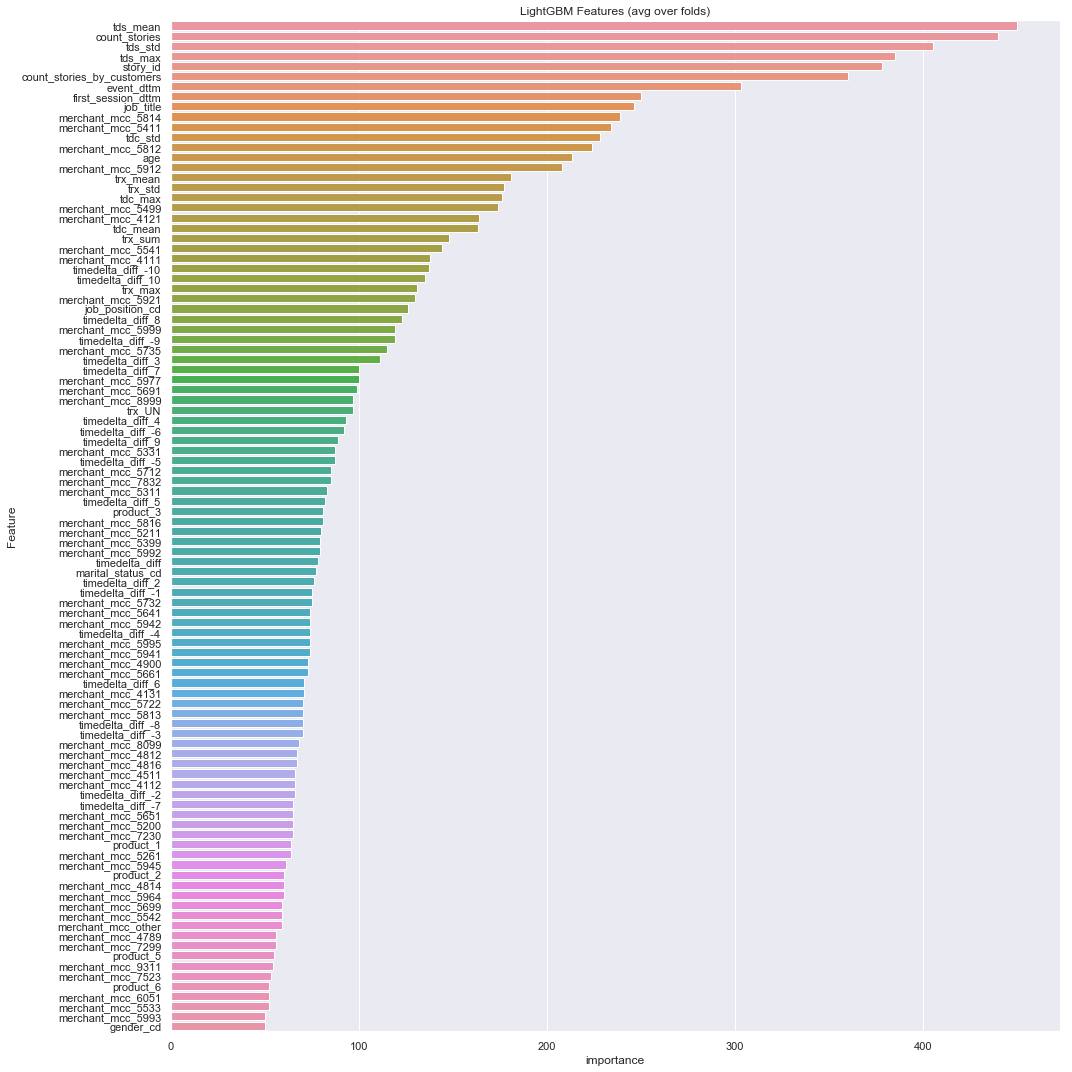

In [35]:
feature_importance_df["Feature"] = feature_importance_df["Feature"].str.strip('()')

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(15,15))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
preds = pd.DataFrame(predictions)
preds.columns = ['dislike','skip','view','like']
preds.to_pickle('preds')

In [ ]:
sample = pd.read_csv('sample_submit.csv')
sample['score'] = (-10)*preds['dislike'] + (-0.1)*preds['skip'] + 0.1*preds['view'] + 0.5*preds['like']
sample.loc[sample['score']<0,'score'] = -1
sample.loc[sample['score']>=0,'score'] = 1
sample.to_csv('submission.csv',index=False)